# A SIR model approach to study a Psychometric Network

### A project by Irene Silvestro for the Digital Epidemiology exam

In this notebook:<br><br>
**1) Introduction**  
**2) Compartimental Model: studying parameters, endemic state and R0 definition**  
**3) Defining Contact Matrices using the Psychometric Adjacency Matrix**  
**4) Centrality Metrics**  
**5) Stochastic Compartimental Model with Contact Matrices: studying Initialization of Infected Nodes and R0 Definition**  
**6) Stochastic Compartimental Model with Contact Matrices and Random Infections over time**  
**7) Stochastic Compartimental Model with Contact Matrices, Random Infections and Permanent Node Recovery over Time: exploring Strategies of "Vaccination" through Centrality Metrics**



In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

## 1) Introduction



##### - Psychometric Network and Intraindividual Dynamic Network Analysis (IDNA)


**Psychometric Network Analysis** is an approach used in psychology to understand the relationships between psychopathological symptoms. In [the paper under consideration](https://pubmed.ncbi.nlm.nih.gov/29937621/), this approach is applied through an **Intraindividual Dynamic Network Analysis (IDNA)**, which allows the study of dynamic relationships between symptoms within a single individual. The participant in the case study was a 44-year-old woman diagnosed with **major depressive disorder, persistent depressive disorder (dysthymia), and social anxiety disorder**, assessed using the **Structured Clinical Interview for DSM-IV (SCID-IV).**


Specifically, the IDNA is based on **lag-1 partial correlations** between symptoms, that is, the partial correlations between symptoms at time \(t-1\) and time \(t\), **controlling for all other symptoms**. To ensure robustness given the relatively small number of observations, the lag-1 partial correlation matrix was **regularized using LASSO**, which shrinks statistically unreliable estimates to zero, resulting in a sparser and more stable network. The symptoms considered were derived from **22 items of the Individualized Daily Questionnaire (IDQ)**, selected from five main scales: **Depression, Anxiety, Mixed, Anhedonia, and Positive Affect**. The participant completed **90 daily questionnaires over a period of 122 days**, providing longitudinal data sufficient to estimate the dynamic relationships between symptoms.  

The resulting graph is **directed**, with **19 nodes** representing symptoms and edges representing the lag-1 partial correlations between them. The **thickness of the edges** indicates the strength of the relationship, the **color** differentiates positive (green) from negative (red) relations, and the **arrows** indicate directionality, i.e., how a symptom at time \(t-1\) predicts another symptom at time \(t\). Nodes with stronger partial relations are located at the center of the network, while those with weaker associations are positioned at the periphery.  

Thus, this is an **intraindividual network**, built on a single patient, which allows the study of symptom interactions in a dynamic and personalized manner. This approach provides valuable information for **clinical assessment** and for **planning individualized therapeutic interventions**, especially in complex cases with multiple comorbidities.

##### - My project

The **aim of this notebook** is to apply several epidemiological tools to this case study and to explore the potential outcomes under different hypothetical scenarios. In particular, I assumed the **lag-1 correlation matrix as a proxy for the probability of contagion** between nodes, as suggested in the paper.

I then analyzed **centrality metrics** to examine how they influence the spread of symptom activation over time. Finally, I investigated a longer-term dynamic by introducing **random node activation every 10 time steps** and **“node removal” every 300 time steps**, simulating the potential effects of **psychotherapeutic intervention on symptoms**—removing them from the network as if they were “healed”—to observe how the propagation continues and whether the **order of node removal** affects the number of activated nodes over time.  

The **following sections** will describe in greater detail the procedures and analyses conducted in this notebook.


The simulations were conducted purely to investigate, in a modeling context, the behavior of the stochastic differential equations, acknowledging that the assumptions made are not realistic in real-life scenarios.


## 2) Compartimental Model: studying parameters, endemic state and R0 definition

As a first step, deterministic differential equations were used to represent the intended dynamics.


\begin{align*}
\frac{dS}{dt} &= -\beta \frac{ I}{N} S \\
\frac{dI}{dt} &= \beta \frac{I}{N} S - \mu I + \beta_1 \frac{I}{N} R - \alpha \frac{I}{N} I\\
\frac{dR}{dt} &= \mu I - \beta_1 \frac{I}{N} R + \alpha \frac{I}{N} I
\end{align*}

> **Note:** A **contagion from I → R** is also included, representing contact with another infected node.  
> This mechanism is intended to capture the effect of **negative partial correlations** between symptoms, which will be discussed in later sections.



In [2]:
def ire_model(mu, alpha, beta, beta_1, N, I0, T_final, dt=1):

    S, I, R = [N - I0], [I0], [0]
    steps = np.arange(0, T_final + dt, dt)
    for t in range(1, len(steps)):
        
        new_inf = beta * S[t-1] * I[t-1] / N * dt
        new_rec = mu * I[t-1] * dt
        new_rec_1 = alpha * I[t-1] / N * I[t-1] * dt
        new_inf_1 = beta_1 * I[t-1] / N * R[t-1] * dt
    
        S.append(S[t-1] - new_inf )
        I.append(I[t-1] + new_inf - new_rec + new_inf_1 - new_rec_1)
        R.append(R[t-1] + new_rec - new_inf_1 + new_rec_1)

    return np.array(S), np.array(I), np.array(R), np.array(steps)

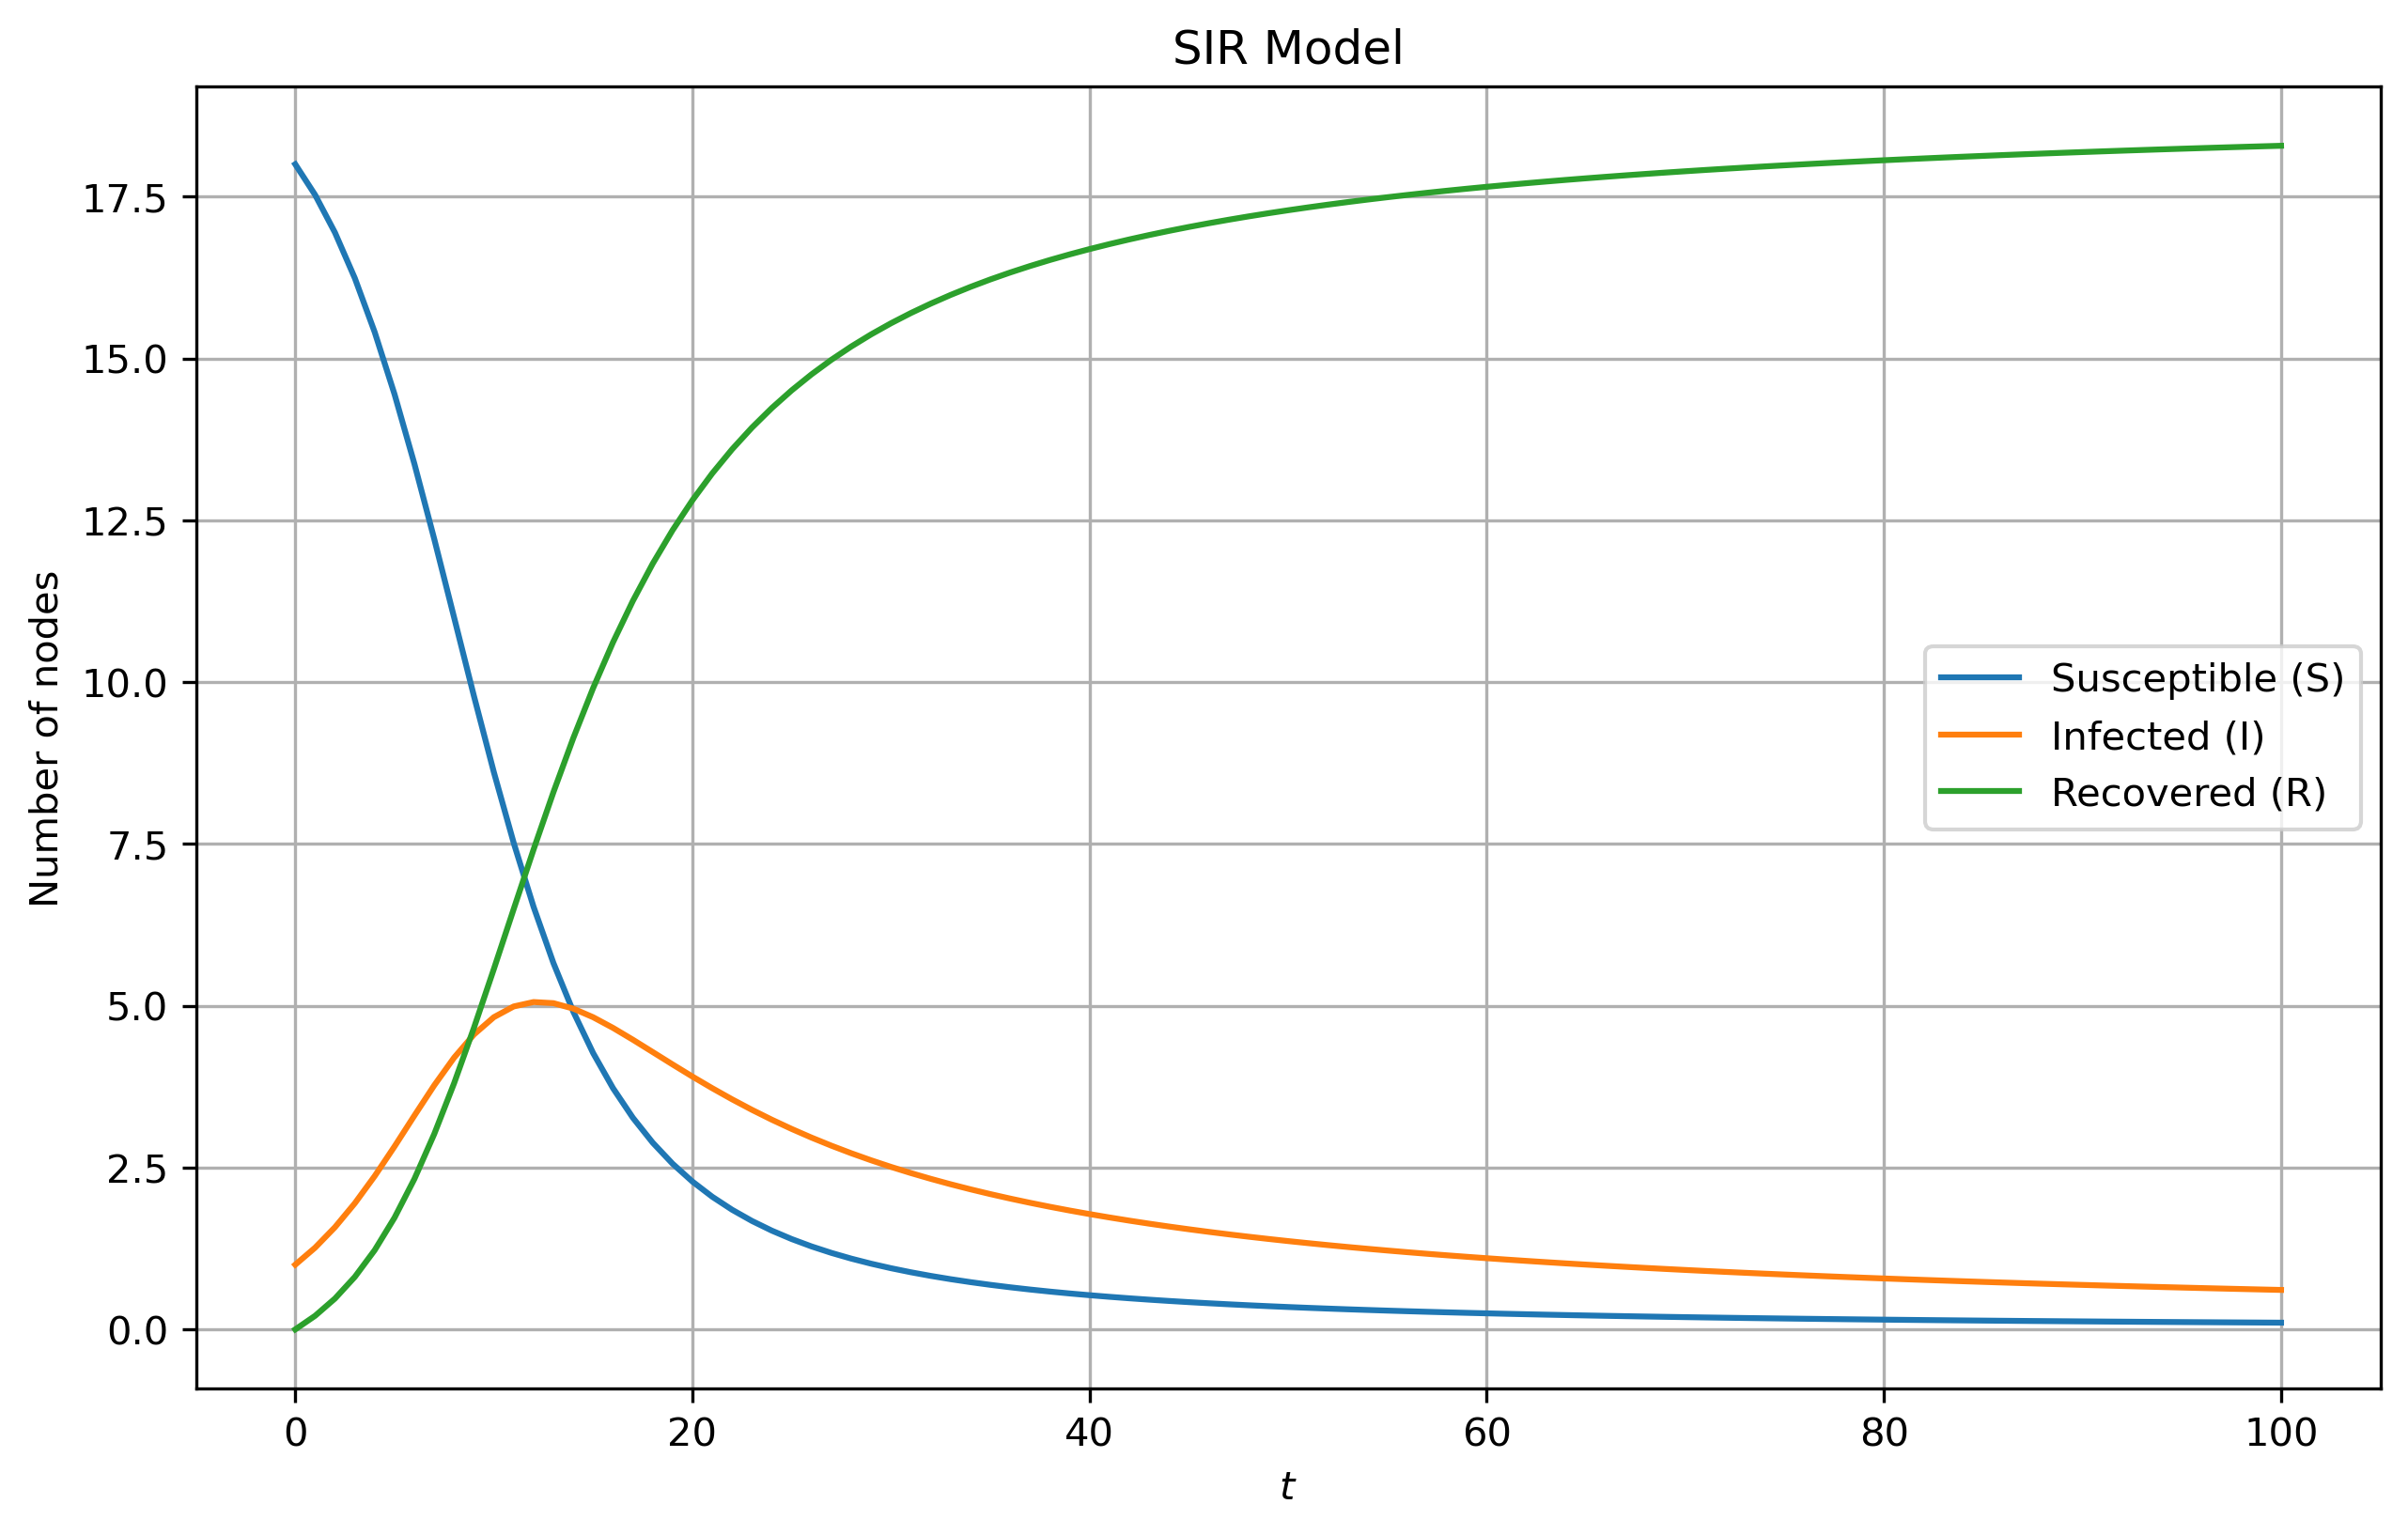

In [3]:
S, I, R, steps = ire_model(mu=0.2, alpha=0.2, beta=0.5, beta_1=0.2,  N=19, I0=1, T_final=100, dt=1)

# plot
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(steps, S, label='Susceptible (S)')
plt.plot(steps, I, label='Infected (I)')
plt.plot(steps, R, label='Recovered (R)')

plt.xlabel('$t$')
plt.ylabel('Number of nodes')
plt.title('SIR Model')
plt.legend()
plt.grid(True)
plt.show()

For this set of equations, using the **early-stage approximation** for the $I$ equation, we obtain:

$$
R_0 = \frac{\beta}{\mu}
$$

It can also be shown that the **endemic equilibrium state** (i.e., the equilibrium different from the disease-free state) has an $I^*$ value of:

$$
I^* = \frac{ (\beta_1 - \mu)}{\alpha + \beta_1} N
$$

In [4]:
def ire_analytical_solution(beta, beta_1, alpha, mu, N):
    return  ((beta_1 - mu)/(alpha + beta_1) )* N

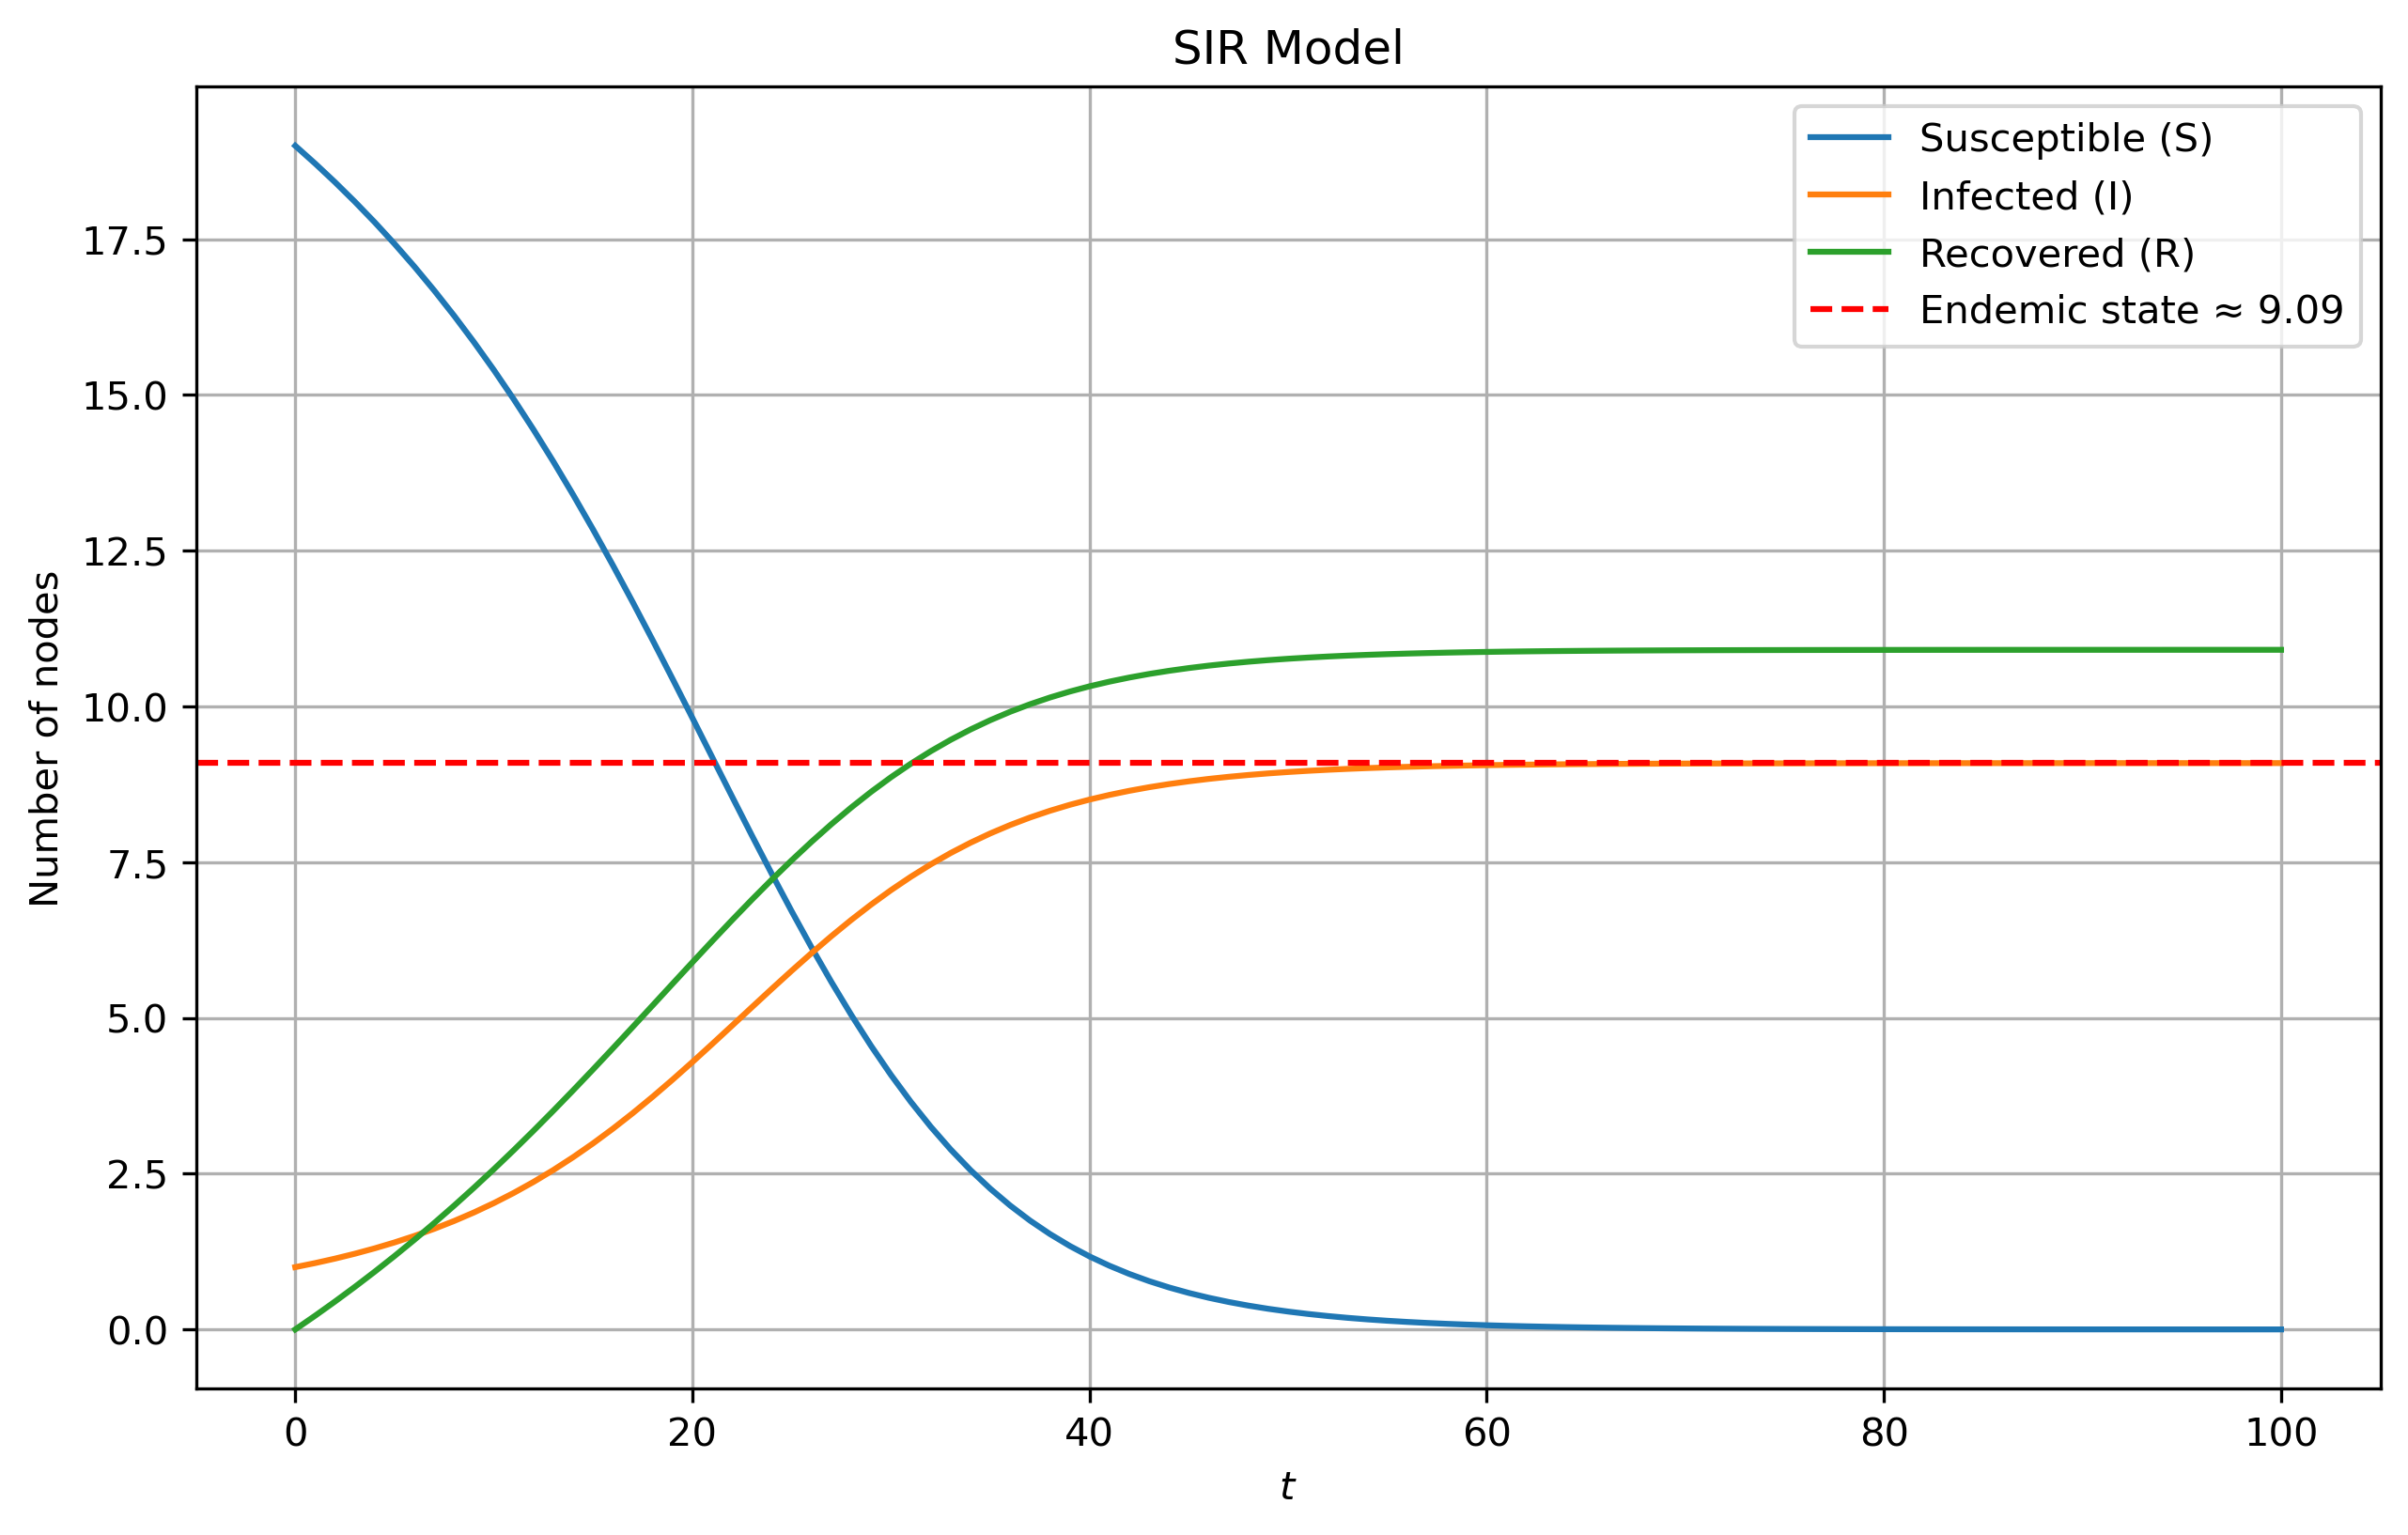

In [5]:
mu=0.2     
alpha=0.4
beta=0.3   
beta_1= 0.7
N= 20   
I0=1      
T_final=100 
dt=1   

S, I, R, steps = ire_model(mu=mu, alpha=alpha, beta=beta, beta_1=beta_1, N=N, I0=I0, T_final=T_final, dt=dt)


# Calculate the endemic state
endemic_state = ire_analytical_solution(beta=beta, beta_1=beta_1, alpha=alpha, mu=mu, N=N)

# Original plot + dashed line
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(steps, S, label='Susceptible (S)')
plt.plot(steps, I, label='Infected (I)')
plt.plot(steps, R, label='Recovered (R)')

# Add dashed line for the endemic state
plt.axhline(y=endemic_state, color='red', linestyle='--', label=f'Endemic state ≈ {endemic_state:.2f}')

plt.xlabel('$t$')
plt.ylabel('Number of nodes')
plt.title('SIR Model')
plt.legend()
plt.grid(True)
plt.show()


## 3) Defining Contact Matrices using the Psychometric Adjacency Matrix


  <img src="https://raw.githubusercontent.com/iresil16/digital_epidemiology/main/graph.png" alt="Graph" width="500"/>



This is the graphical representation of the lag-1 correlation matrix, from which, using the values extracted from the table in [the paper](https://pubmed.ncbi.nlm.nih.gov/29937621/), I created three separate `.xlsx` files.  

Specifically, the **positive values** were used to construct a matrix of positive contacts, where the weight of each link serves as a proxy for the probability of contagion from **S → I** and **R → I** (through contact with another infected node). In the model, it was assumed that a recovered node could become infected again.  

Additionally, **negative correlations** were used to simulate a “negative contagion”, serving as a proxy for the probability of transition from **I → R**  (through contact with another infected node) . As explained in the paper, if at time \(t-1\) a symptom \(i\) was negatively correlated with another node \(j\), the latter (if infected at \(t-1\)) has a higher probability of disappearing (recovering) at time \(t\).

*Example reported from the article : "the arrow
pointing from Discouraged to Worry represents the relation between Discouraged at time t– 1 (yesterday) and
Worry at time t (today), controlling for all other symptoms, including Worry yesterday."*


##### Creation and visualization of .xlsx files 

In [47]:
'''
# List of symptom names (columns and rows)
nodes = ["Sad", "Depressed", "Discourage", "Disappt", "Blame", "Nervous", "Tense", 
         "Uneasy", "Un relax", "On edge", "Worry", "Trb Conc", "Confused", "Not enjoy",
         "Withdraw", "Extra Effort", "Slow", "Fun", "Energy"]

# Lag-1 partial correlation matrix
data = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.099, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, -0.144, 0, 0, 0, -0.054, 0, 0, 0, 0, 0, 0, 0],
    [0.095, 0, 0.348, 0, 0, 0, 0, 0, 0, 0, 0.232, 0.206, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0.06, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [-0.084, 0, -0.222, 0, 0, 0, 0, 0, 0, 0, 0, -0.104, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.179, 0, 0, 0, 0, 0, -0.196, 0, 0, 0],
    [0.227, 0, 0, 0, 0, 0, 0.107, 0.227, 0, 0, 0, 0, 0, 0.075, 0.113, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0.059, 0, 0, 0, 0, 0.322, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0.071, 0, 0, 0, 0, 0, 0.101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0.188, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0.127, 0.046, 0.226, 0.076, 0, 0.143, 0, 0, 0, 0, -0.094, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.163, 0, 0.164, 0.062, 0.184, 0.094, 0, -0.048],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.088, -0.161, 0, 0.035, 0, 0, 0],
    [0.191, 0, 0.068, 0, 0, 0, 0, 0, 0, 0, 0, -0.057, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.132, 0, -0.051, 0, 0, 0, 0, 0],
    [0, 0, 0.144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, -0.117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, -0.014, 0, 0, 0, 0, 0, 0, 0, 0, -0.159, 0, -0.178, 0, -0.063, -0.074, 0, 0.101]
]

# Create DataFrame
df = pd.DataFrame(data, index=nodes, columns=nodes)

# Destination folder
folder_path = "/Users/irenesilvestro/Desktop/quinto anno uni/epidemiologia/progetto_epidemiologia/data"

#Create positive-only matrix
df_pos = df.copy()
df_pos[df_pos < 0] = 0
file_path_pos = os.path.join(folder_path, "corr_pos.xlsx")
df_pos.to_excel(file_path_pos, engine="openpyxl")

#Create negative-only matrix
df_neg = df.copy()
df_neg[df_neg > 0] = 0
file_path_neg = os.path.join(folder_path, "corr_neg.xlsx")
df_neg.to_excel(file_path_neg, engine="openpyxl")

#Create full matrix
df_tot = df.copy()
file_path_tot = os.path.join(folder_path, "corr_tot.xlsx")
df_tot.to_excel(file_path_tot, engine="openpyxl")

'''

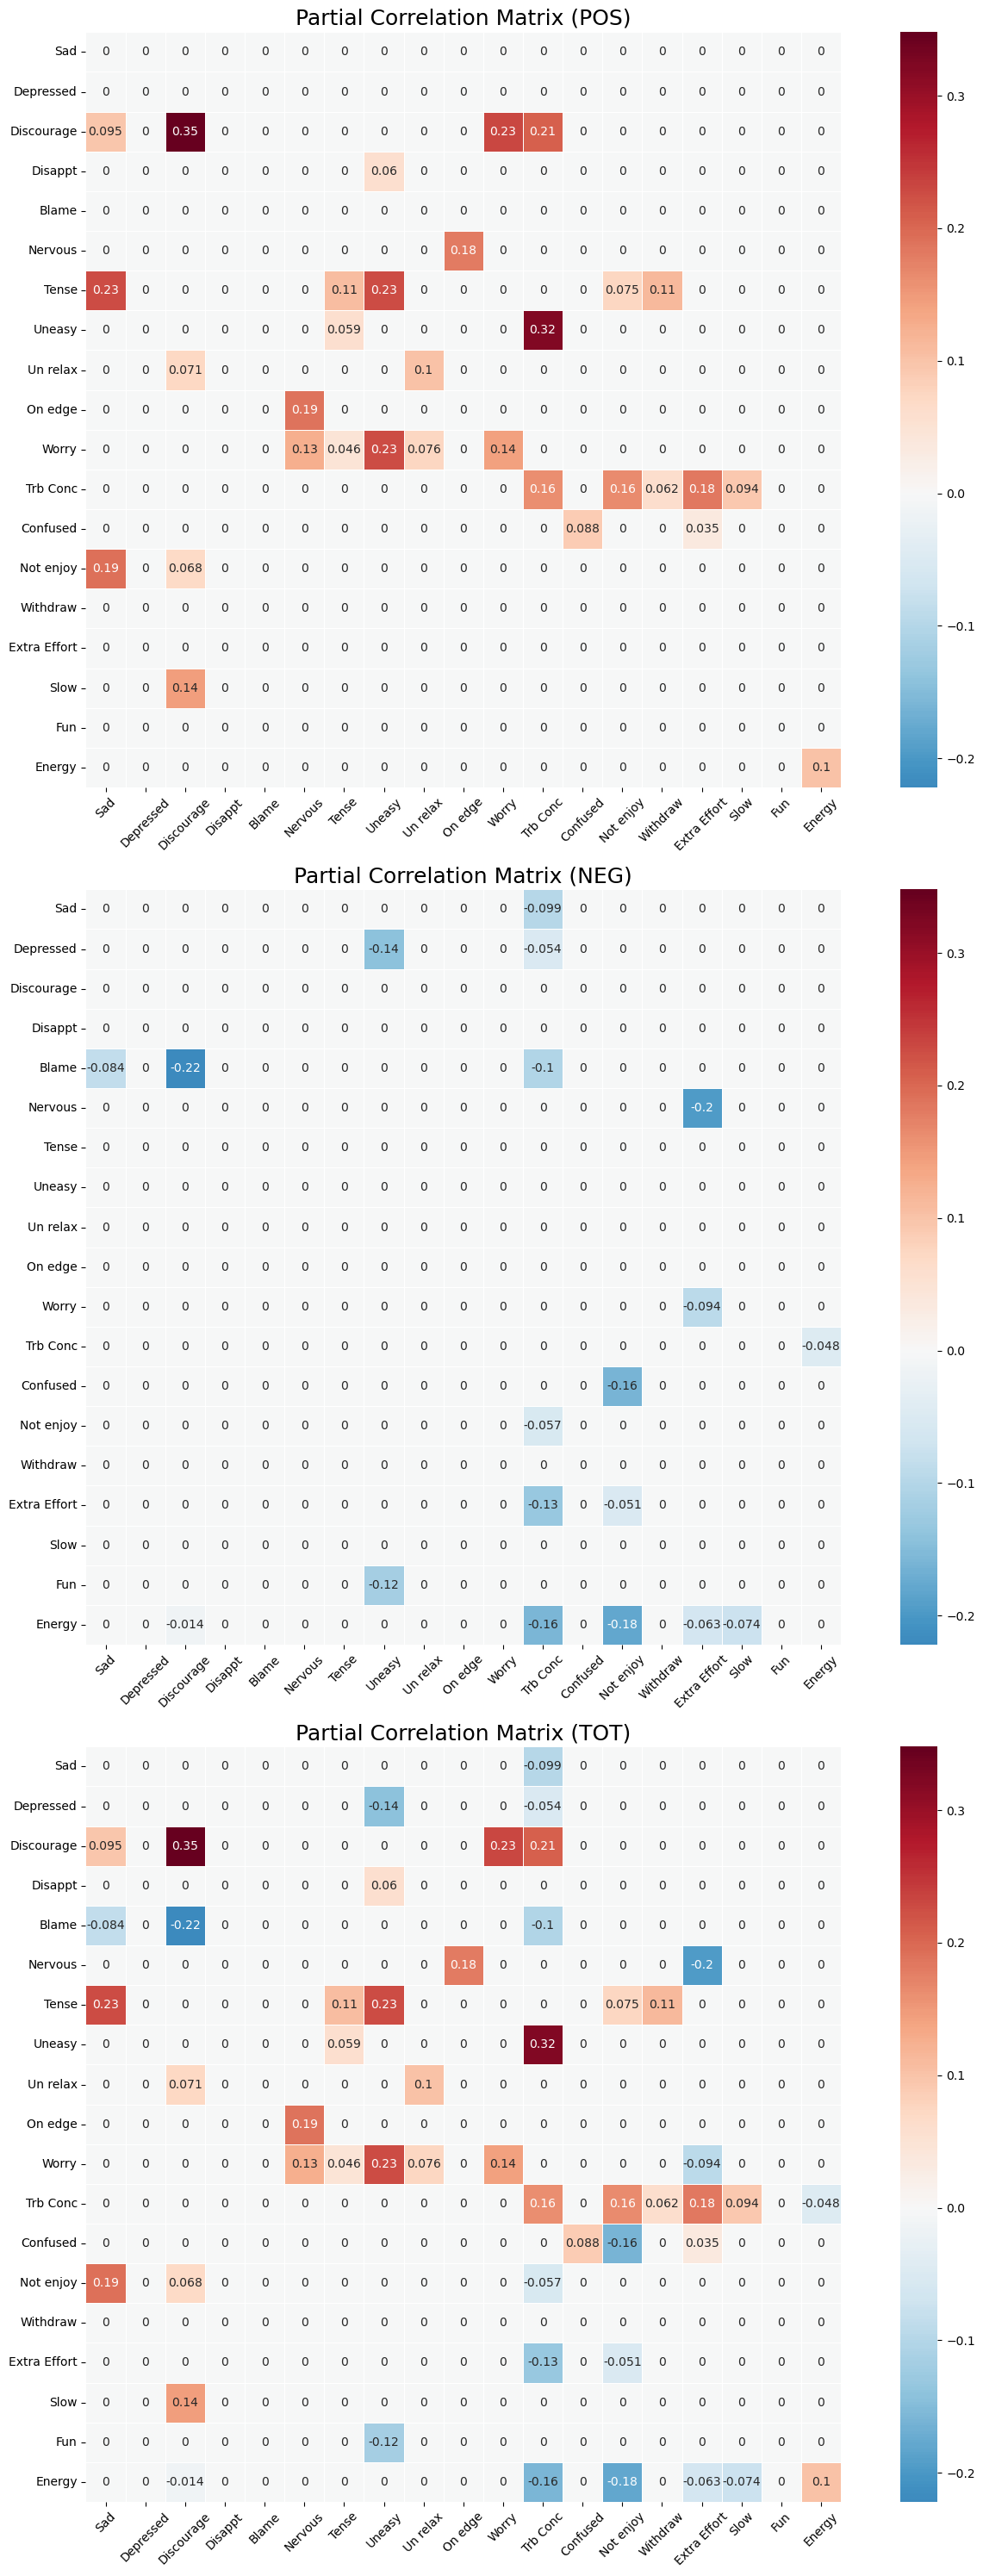

In [6]:
# Reading data
contacts_pos = pd.read_excel("../data/corr_pos.xlsx", index_col=0)
contacts_neg = pd.read_excel("../data/corr_neg.xlsx", index_col=0)
contacts_tot = pd.read_excel("../data/corr_tot.xlsx", index_col=0)

# Optional: calculate the same range for the color scale
vmin = min(contacts_pos.min().min(), contacts_neg.min().min(), contacts_tot.min().min())
vmax = max(contacts_pos.max().max(), contacts_neg.max().max(), contacts_tot.max().max())

# Create figure with three subplots (three rows, one column)
fig, axes = plt.subplots(3, 1, figsize=(14, 30))  # 3 rows, 1 column

# First heatmap (corr_pos)
sns.heatmap(
    contacts_pos,
    annot=True,
    cmap="RdBu_r",
    center=0,
    vmin=vmin, vmax=vmax,          
    linewidths=0.5,
    square=True,
    ax=axes[0]
)
axes[0].set_title("Partial Correlation Matrix (POS)", fontsize=18)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Second heatmap (corr_neg)
sns.heatmap(
    contacts_neg,
    annot=True,
    cmap="RdBu_r",
    center=0,
    vmin=vmin, vmax=vmax,          
    linewidths=0.5,
    square=True,
    ax=axes[1]
)
axes[1].set_title("Partial Correlation Matrix (NEG)", fontsize=18)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

# Third heatmap (corr_tot)
sns.heatmap(
    contacts_tot,
    annot=True,
    cmap="RdBu_r",
    center=0,
    vmin=vmin, vmax=vmax,          
    linewidths=0.5,
    square=True,
    ax=axes[2]
)
axes[2].set_title("Partial Correlation Matrix (TOT)", fontsize=18)
axes[2].tick_params(axis='x', rotation=45)
axes[2].tick_params(axis='y', rotation=0)


plt.tight_layout()
plt.show()

## 4) Centrality Metrics

Here different centrality metrics are computed, defining lists of indeces that will be used in the final section.


In [7]:
def import_contact_matrix(filename):
    df = pd.read_excel(filename, header=None)
    numeric_df = df.iloc[1:, 1:]     
    numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce').fillna(0)

    return numeric_df.to_numpy(dtype=float)

contacts_pos = import_contact_matrix("../data/corr_pos.xlsx")
contacts_neg = import_contact_matrix("../data/corr_neg.xlsx")
contacts_tot = import_contact_matrix("../data/corr_tot.xlsx")


In [8]:
outdegree_pos = np.sum(np.abs(contacts_pos), axis=1)
indegree_pos = np.sum(np.abs(contacts_pos), axis=0)

# Read labels
cols = pd.read_excel("../data/corr_pos.xlsx", header=None).iloc[0,1:].tolist()

degree_pos = pd.DataFrame({
    "Node": cols,
    "Outdegree": outdegree_pos,
    "Indegree": indegree_pos
})

print(degree_pos)

# Top 4 nodes with highest Outdegree
top4_outdegree = degree_pos.nlargest(4, "Outdegree")
print("\n--- Top 4 Outdegree_positive ---")
print(top4_outdegree[["Node", "Outdegree"]])

# Top 4 nodes with lowest Outdegree
bottom4_outdegree = degree_pos.nsmallest(4, "Outdegree")
print("\n--- Bottom 4 Outdegree ---")
print(bottom4_outdegree[["Node", "Outdegree"]])

# Top 4 nodes with highest Indegree
top4_indegree = degree_pos.nlargest(4, "Indegree")
print("\n--- Top 4 Indegree_positive ---")
print(top4_indegree[["Node", "Indegree"]])



            Node  Outdegree  Indegree
0            Sad      0.000     0.513
1      Depressed      0.000     0.000
2     Discourage      0.881     0.631
3        Disappt      0.060     0.000
4          Blame      0.000     0.000
5        Nervous      0.179     0.315
6          Tense      0.749     0.212
7         Uneasy      0.381     0.513
8       Un relax      0.172     0.177
9        On edge      0.188     0.179
10         Worry      0.618     0.375
11      Trb Conc      0.667     0.691
12      Confused      0.123     0.088
13     Not enjoy      0.259     0.239
14      Withdraw      0.000     0.175
15  Extra Effort      0.000     0.219
16          Slow      0.144     0.094
17           Fun      0.000     0.000
18        Energy      0.101     0.101

--- Top 4 Outdegree_positive ---
          Node  Outdegree
2   Discourage      0.881
6        Tense      0.749
11    Trb Conc      0.667
10       Worry      0.618

--- Bottom 4 Outdegree ---
         Node  Outdegree
0         Sad        0.

In [9]:
# Sort the DataFrame by Outdegree in descending order
sorted_outdegree = degree_pos.sort_values(by="Outdegree", ascending=False)

# Extract the ordered indices
outdegree_pos_descendent = sorted_outdegree.index.tolist()

# Starting from the descending list
outdegree_pos_ascendent = outdegree_pos_descendent[::-1]

#print(outdegree_pos_descendent)
#print(outdegree_pos_ascendent)



In [10]:
outdegree_neg = np.sum(np.abs(contacts_neg), axis=1)
indegree_neg = np.sum(np.abs(contacts_neg), axis=0)

# Read labels
cols = pd.read_excel("../data/corr_neg.xlsx", header=None).iloc[0,1:].tolist()

degree_neg = pd.DataFrame({
    
    "Node": cols,
    "Outdegree": outdegree_neg,
    "Indegree": indegree_neg
})


#print(degree_neg)

# Top 4 nodes with highest Outdegree
top4_outdegree = degree_neg.nlargest(4, "Outdegree")
print("\n--- Top 4 Outdegree_negative ---")
print(top4_outdegree[["Node", "Outdegree"]])


# Top 4 nodes with highest Indegree
top4_indegree = degree_neg.nlargest(4, "Indegree")
print("\n--- Top 4 Indegree_negative ---")
print(top4_indegree[["Node", "Indegree"]])




--- Top 4 Outdegree_negative ---
         Node  Outdegree
18     Energy      0.488
4       Blame      0.410
1   Depressed      0.198
5     Nervous      0.196

--- Top 4 Indegree_negative ---
            Node  Indegree
11      Trb Conc     0.605
13     Not enjoy     0.390
15  Extra Effort     0.353
7         Uneasy     0.261


In [11]:
import networkx as nx

# Create a binary matrix: 1 if positive, 0 if zero or negative
binary_matrix = (contacts_pos > 0).astype(int)

# Create the graph using NetworkX
G = nx.from_numpy_array(binary_matrix)

# Compute the betweenness of the nodes
betweenness_pos = nx.betweenness_centrality(G)

# Read node labels (names) from your Excel
cols = pd.read_excel("../data/corr_pos.xlsx", header=None).iloc[0, 1:].tolist()

degree_pos = pd.DataFrame({
    "Node": cols,
    "Betweenness": [betweenness_pos[i] for i in range(len(cols))]
})

# Top 4 nodes with highest betweenness
top4_betweenness = degree_pos.nlargest(4, "Betweenness")
print("\n--- Top 4 Betweenness_positive ---")
print(top4_betweenness[["Node", "Betweenness"]])



--- Top 4 Betweenness_positive ---
          Node  Betweenness
11    Trb Conc     0.215686
10       Worry     0.189542
2   Discourage     0.133987
7       Uneasy     0.122004


In [12]:
# Sort the nodes by betweenness in descending order
betweeness_pos_descendent = sorted(betweenness_pos, key=lambda x: betweenness_pos[x], reverse=True)

betweeness_pos_ascendent = betweeness_pos_descendent[::-1]

#print(betweeness_pos_descendent)
#print(betweeness_pos_ascendent)

In [13]:
# Calculate the clustering coefficient of nodes
clustering_pos = nx.clustering(G)

# Read node labels (names) from your Excel
cols = pd.read_excel("../data/corr_pos.xlsx", header=None).iloc[0, 1:].tolist()

# Create the DataFrame with names and clustering
clustering_df = pd.DataFrame({
    "Node": cols,
    "Clustering": [clustering_pos[i] for i in range(len(cols))]
})

# The 4 nodes with the highest clustering
top4_clustering = clustering_df.nlargest(4, "Clustering")
print("\nTop 4 Clustering_positive")
print(top4_clustering[["Node", "Clustering"]])



Top 4 Clustering_positive
         Node  Clustering
8    Un relax    1.000000
16       Slow    1.000000
0         Sad    0.666667
13  Not enjoy    0.500000


In [14]:
# Sort nodes by betweenness in descending order
clustering_pos_descendent = sorted(clustering_pos, key=lambda x: clustering_pos[x], reverse=True)

clustering_pos_ascendent = clustering_pos_descendent[::-1]

#print(clustering_pos_descendent)
#print(clustering_pos_ascendent)


## 5) Stochastic Compartimental Model with Contact Matrices: studying Initialization of Infected Nodes and R0 Definition

In this section I define the set of differential equation that define the dynamics on the graph. 

The stochastic dynamics for each node \(k\) can be described as follows:

\begin{align*}
\frac{dS_k}{dt} &= - \beta \, S_k \sum_{j=1}^{n_\text{nodes}} \frac{C_{jk} I_j}{N_k} \\[2mm]
\frac{dI_k}{dt} &= \beta \, S_k \sum_{j=1}^{n_\text{nodes}} \frac{C_{jk} I_j}{N_k} 
                   - \mu \, I_k
                   + \beta \, R_k \sum_{j=1}^{n_\text{nodes}} \frac{C_{jk} I_j}{N_k}
                   - I_k \sum_{j=1}^{n_\text{nodes}} \beta \frac{(C_\text{neg jk}) I_j}{N_k} \\[1mm]
\frac{dR_k}{dt} &= \mu \, I_k 
                   - \beta \, R_k \sum_{j=1}^{n_\text{nodes}} \frac{C_{jk} I_j}{N_k} 
                   + I_k \sum_{j=1}^{n_\text{nodes}} \beta \frac{(C_\text{neg})_{jk} I_j}{N_k}
\end{align*}

Note that $k$ is the **index of a node** and not a class, as in the classical contact matrix approach. Therefore, each node can only occupy **one compartment at a time**. The dynamics of each node depend both on its current state and on the states of the nodes it can potentially contact. For this reason, in the following simulations, $N_k$ is always set to 1.

The previously defined matrices $C$ and $C_\text{neg}$ are used as **contact matrices**, encoding the graph underlying structure, i.e., which nodes can have contact and the probability of contagion in case of contact. This highlights the power of the model: the contagion probability is **heterogeneous** and personalized, thanks to the psychometric network.

For both **positive** ($C$) and **negative** ($C_\text{neg}$) contagion, $\beta$ is fixed at 1, because the actual probability of contagion is already included in the contact matrix. Moreover, in the code, a minus sign is applied to $C_\text{neg}$ to correctly account for the negative coefficients in the matrix.

In the dynamics, two pathways to infection are considered: a node can become infected either from the susceptible state ($S \to I$) or from the recovered state ($R \to I$) through contact with an infected node. Additionally, beyond the standard recovery process with rate $\mu$, a “negative contagion” mechanism is included, allowing an infected node to transition to recovered ($I \to R$) if it interacts with another node that can induce negative influence.



In [15]:
def ire_model_stochastic(beta, mu, C, C_neg, Nk, T_final, dt=1, infected_nodes=None, seed=None):
    """
    Added `seed` parameter to fix randomness.
    """
    if seed is not None:
        rng = np.random.default_rng(seed)  # create a local generator
    else:
        rng = np.random.default_rng()      # random generator
        
    steps = np.arange(0, T_final + dt, dt)
    n_nodes = 19  # number of nodes
    S, I, R = np.zeros((len(steps), n_nodes)), np.zeros((len(steps), n_nodes)), np.zeros((len(steps), n_nodes))
  
    # initialize compartments
    S[0] = Nk.copy()
    I[0] = 0
    
    
    # if list is not provided, no infected
    if infected_nodes is None:
        infected_nodes = []

    # set initially infected nodes
    for node in infected_nodes:
        I[0, node] = 1
        S[0, node] -= 1


    # simulate
    for t in range(1, len(steps)):
        S_next, I_next, R_next = S[t-1].copy(), I[t-1].copy(), R[t-1].copy()
        for k in range(n_nodes):
            new_infected_k = rng.binomial(S[t-1, k], beta * np.sum(C.T[k, :] * I[t-1, :] / Nk) * dt)
            new_recovered_k = rng.binomial(I[t-1, k], mu * dt)
            new_infected_k_1 = rng.binomial(R[t-1, k], beta * np.sum(C.T[k, :] * I[t-1, :] / Nk) * dt)
            new_recovered_k_1 = rng.binomial(I[t-1, k], np.sum(- beta * C_neg.T[k, :] * I[t-1, :] / Nk) * dt)

            S_next[k] = S[t-1, k] - new_infected_k
            I_next[k] = I[t-1, k] + new_infected_k - new_recovered_k + new_infected_k_1 - new_recovered_k_1
            R_next[k] = R[t-1, k] + new_recovered_k - new_infected_k_1 + new_recovered_k_1
            
           
        # transform to 0 or 1 and ensure only one is 1
        # to correct possible -1 and +2 for the case of I
            if S_next[k] > 0:
                S_next[k], I_next[k], R_next[k] = 1, 0, 0
            elif I_next[k] > 0:
                S_next[k], I_next[k], R_next[k] = 0, 1, 0
            elif R_next[k] > 0:
                S_next[k], I_next[k], R_next[k] = 0, 0, 1
    
            
        S[t] = S_next
        I[t] = I_next
        R[t] = R_next
        
    return np.array(S), np.array(I), np.array(R), np.array(steps)


In [16]:
C = contacts_pos
C_neg = contacts_neg
Nk = np.array([1]*19) 

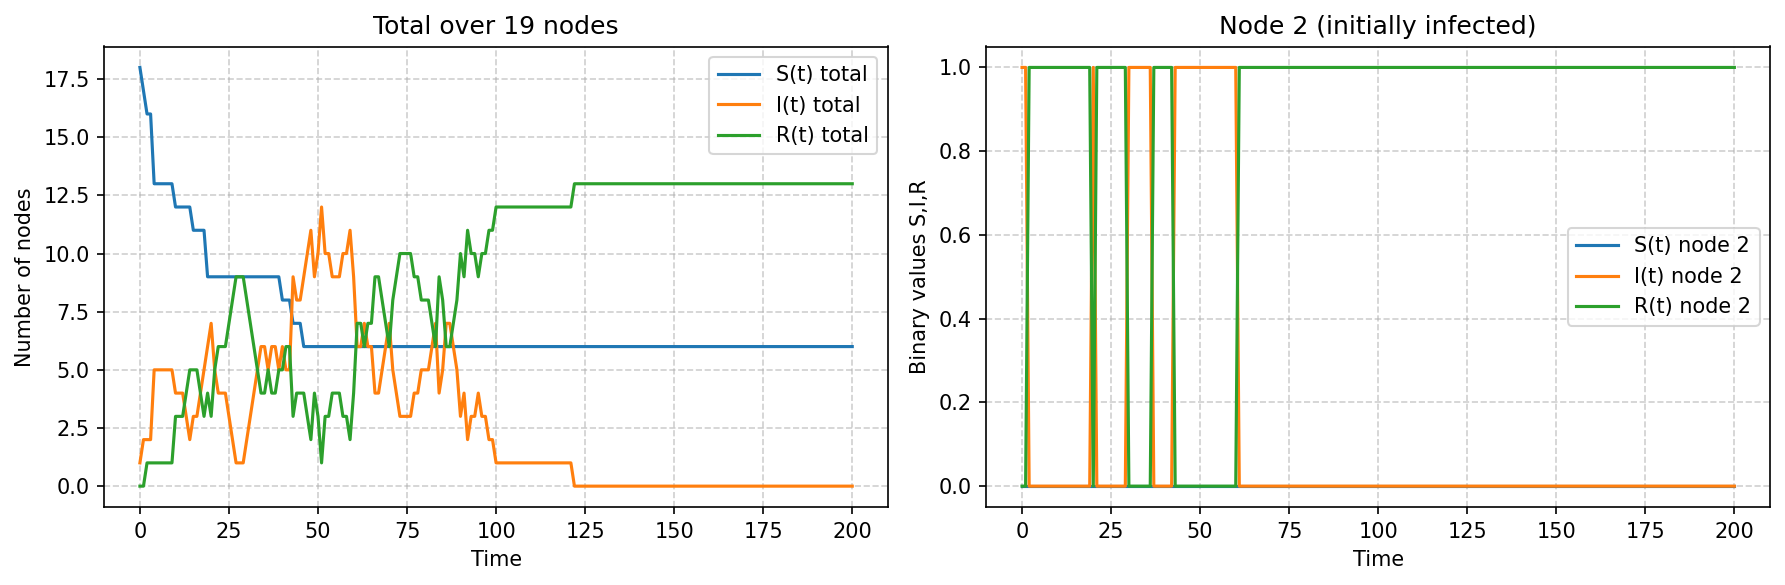

In [17]:
#infected = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]   # warning: if starting from 0, 3 is the fourth node

infected = [2]
#infected = [8,16,0] nodes with highest positive outdegree
#infected = [11,10,2] nodes with lower positive outdegree
#infected = [18,1,4] nodes with highest negative outdegree
#infected = [0,1,4] nodes with highest betweenness
#infected = [2,6,11] nodes with highest clustering coefficient

S, I, R, steps = ire_model_stochastic(
    beta=1,
    mu=0.1,
    C=C,
    C_neg=C_neg,
    Nk=Nk,
    T_final=200,
    dt=1,
    infected_nodes=infected,
    seed=42 
)

total_S = np.sum(S, axis=1)
total_I = np.sum(I, axis=1)
total_R = np.sum(R, axis=1)

# Node 2
node2_S = S[:, 2]
node2_I = I[:, 2]
node2_R = R[:, 2]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

# Total plot
axes[0].plot(total_S, label="S(t) total")
axes[0].plot(total_I, label="I(t) total")
axes[0].plot(total_R, label="R(t) total")
axes[0].set_title("Total over 19 nodes")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Number of nodes")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.6)

# Node 2 plot
axes[1].plot(node2_S, label="S(t) node 2")
axes[1].plot(node2_I, label="I(t) node 2")
axes[1].plot(node2_R, label="R(t) node 2")
axes[1].set_title("Node 2 (initially infected)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Binary values S,I,R")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


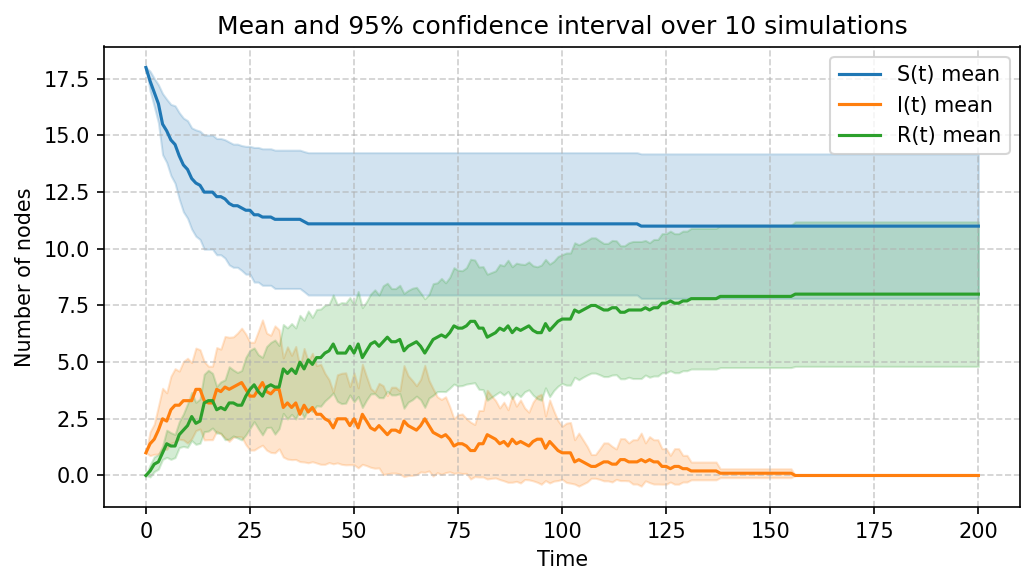

In [18]:
infected = [2]
#infected = [8,16,0]
#infected = [11,10,2]
#infected = [18,1,4]
#infected = [0,1,4]
#infected = [2,6,11]

num_sim = 10
seeds = range(num_sim)

# Lists to save results
S_all, I_all, R_all = [], [], []

for seed in seeds:
    S, I, R, steps = ire_model_stochastic(
        beta=1,
        mu=0.1,
        #mu=0.01,
        C=C,
        C_neg=C_neg,
        Nk=Nk,
        T_final=200,
        dt=1,
        infected_nodes=infected,
        seed=seed
    )

    total_S = np.sum(S, axis=1)
    total_I = np.sum(I, axis=1)
    total_R = np.sum(R, axis=1)

    S_all.append(total_S)
    I_all.append(total_I)
    R_all.append(total_R)

# Convert to array [num_sim, num_steps]
S_all = np.array(S_all)
I_all = np.array(I_all)
R_all = np.array(R_all)

# Mean and 95% confidence interval
mean_S = np.mean(S_all, axis=0)
mean_I = np.mean(I_all, axis=0)
mean_R = np.mean(R_all, axis=0)

# Calculate 95% CI (approximating with normal distribution)
std_S = np.std(S_all, axis=0, ddof=1)
std_I = np.std(I_all, axis=0, ddof=1)
std_R = np.std(R_all, axis=0, ddof=1)
ci_mult = 1.96 / np.sqrt(num_sim)  # 95% CI
ci_S = std_S * ci_mult
ci_I = std_I * ci_mult
ci_R = std_R * ci_mult

# Plot
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)
time = np.arange(len(mean_S))

# Mean + confidence band
ax.plot(time, mean_S, label="S(t) mean", color="tab:blue")
ax.fill_between(time, mean_S - ci_S, mean_S + ci_S, color="tab:blue", alpha=0.2)

ax.plot(time, mean_I, label="I(t) mean", color="tab:orange")
ax.fill_between(time, mean_I - ci_I, mean_I + ci_I, color="tab:orange", alpha=0.2)

ax.plot(time, mean_R, label="R(t) mean", color="tab:green")
ax.fill_between(time, mean_R - ci_R, mean_R + ci_R, color="tab:green", alpha=0.2)

ax.set_title("Mean and 95% confidence interval over 10 simulations")
ax.set_xlabel("Time")
ax.set_ylabel("Number of nodes")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


##### Computing R0

Following the **next generation matrix approach**, the basic reproduction number $R_0$ can be computed as:

$$
R_0 = \frac{\rho(F)}{\mu}
$$

where $\rho(F)$ is the spectral radius of the matrix $F$, whose elements are defined as:

$$
F_{ij} = \beta \, C_{ji} \, S_0[i] - (-) \, (C_\text{neg})_{ji} \, I_0[i]
$$

Here, $S_0[i]$ and $I_0[i]$ represent the initial states of node $i$ in the susceptible and infected compartments, respectively. This formulation assumes that **none of the nodes are initialized in the recovered compartment**.



In [19]:
def compute_R0(beta, mu, C, C_neg, S0, I0):
    F = C.copy() * 0.0  # initialize F matrix with zeros
    
    n = C.shape[0]
    
    # Build F
    for i in range(n):
        for j in range(n):
            F[i, j] = beta * C.T[i, j] * S0[i] - (- C_neg.T[i, j] * I0[i])

    # Calculate spectral radius (maximum eigenvalue in real part)
    rho_F = np.linalg.eigvals(F).real.max()
    #print(F)
    return rho_F / mu

In [20]:
n_nodes = 19                     # total number of nodes
infected = [2]
#infected = [8,16,0]
#infected = [11,10,2]
#infected = [18,1,4]
#infected = [0,1,4]
#infected = [2,6,11]

# Build initial vectors
S0 = np.ones(n_nodes)             # all susceptible at the beginning
I0 = np.zeros(n_nodes)            # no infected at the beginning

# Set infected nodes
for idx in infected:
    S0[idx] = 0
    I0[idx] = 1


R0_value = compute_R0(beta=1,
                          mu=0.1,
                          C=contacts_pos,
                          C_neg=contacts_neg,
                          S0=S0,
                          I0=I0)

print("Initial R0:", R0_value)

Initial R0: 1.8344481459011046


## 6) Stochastic Compartimental Model with Contact Matrices and Random Infections over time

Now, **random infections over time** are implemented. The aim is to simulate the emergence of new infections as time progresses, reflecting the ongoing dynamics of the individual. Assuming $dt$ represents one day, two new nodes are introduced as infected every 10 $dt$ (days).  

In [21]:
def ire_model_stochastic_RandomInfected(beta, mu, C, C_neg, Nk, T_final, dt=1, infected_nodes=None, seed=None):

    if seed is not None:
        rng = np.random.default_rng(seed)  # local generator
    else:
        rng = np.random.default_rng()      # random generator
        
    steps = np.arange(0, T_final + dt, dt)
    n_nodes = 19  # number of nodes
    S, I, R = np.zeros((len(steps), n_nodes)), np.zeros((len(steps), n_nodes)), np.zeros((len(steps), n_nodes))
  
    # initialize compartments
    S[0] = Nk.copy()
    I[0] = 0
    
    if infected_nodes is None:
        infected_nodes = []

    # set initially infected nodes
    for node in infected_nodes:
        I[0, node] = 1
        S[0, node] -= 1

    # simulation
    for t in range(1, len(steps)):
        S_next, I_next, R_next = S[t-1].copy(), I[t-1].copy(), R[t-1].copy()

        # SIR dynamics
        for k in range(n_nodes):
            new_infected_k = rng.binomial(S[t-1, k], beta * np.sum(C.T[k, :] * I[t-1, :] / Nk) * dt)
            new_recovered_k = rng.binomial(I[t-1, k], mu * dt)
            new_infected_k_1 = rng.binomial(R[t-1, k], beta * np.sum(C.T[k, :] * I[t-1, :] / Nk) * dt)
            new_recovered_k_1 = rng.binomial(I[t-1, k], np.sum(- beta * C_neg.T[k, :] * I[t-1, :] / Nk) * dt)

            S_next[k] = S[t-1, k] - new_infected_k
            I_next[k] = I[t-1, k] + new_infected_k - new_recovered_k + new_infected_k_1 - new_recovered_k_1
            R_next[k] = R[t-1, k] + new_recovered_k - new_infected_k_1 + new_recovered_k_1
            
            # discrete state (0/1)
            if S_next[k] > 0:
                S_next[k], I_next[k], R_next[k] = 1, 0, 0
            elif I_next[k] > 0:
                S_next[k], I_next[k], R_next[k] = 0, 1, 0
            elif R_next[k] > 0:
                S_next[k], I_next[k], R_next[k] = 0, 0, 1

        # EVERY 10 TIMESTEPS: force 2 random nodes to be infected
        if t % 10 == 0:
            random_nodes = rng.choice(n_nodes, size=2, replace=False)
            for node in random_nodes:
                S_next[node], I_next[node], R_next[node] = 0, 1, 0

        S[t] = S_next
        I[t] = I_next
        R[t] = R_next
        
    return np.array(S), np.array(I), np.array(R), np.array(steps)


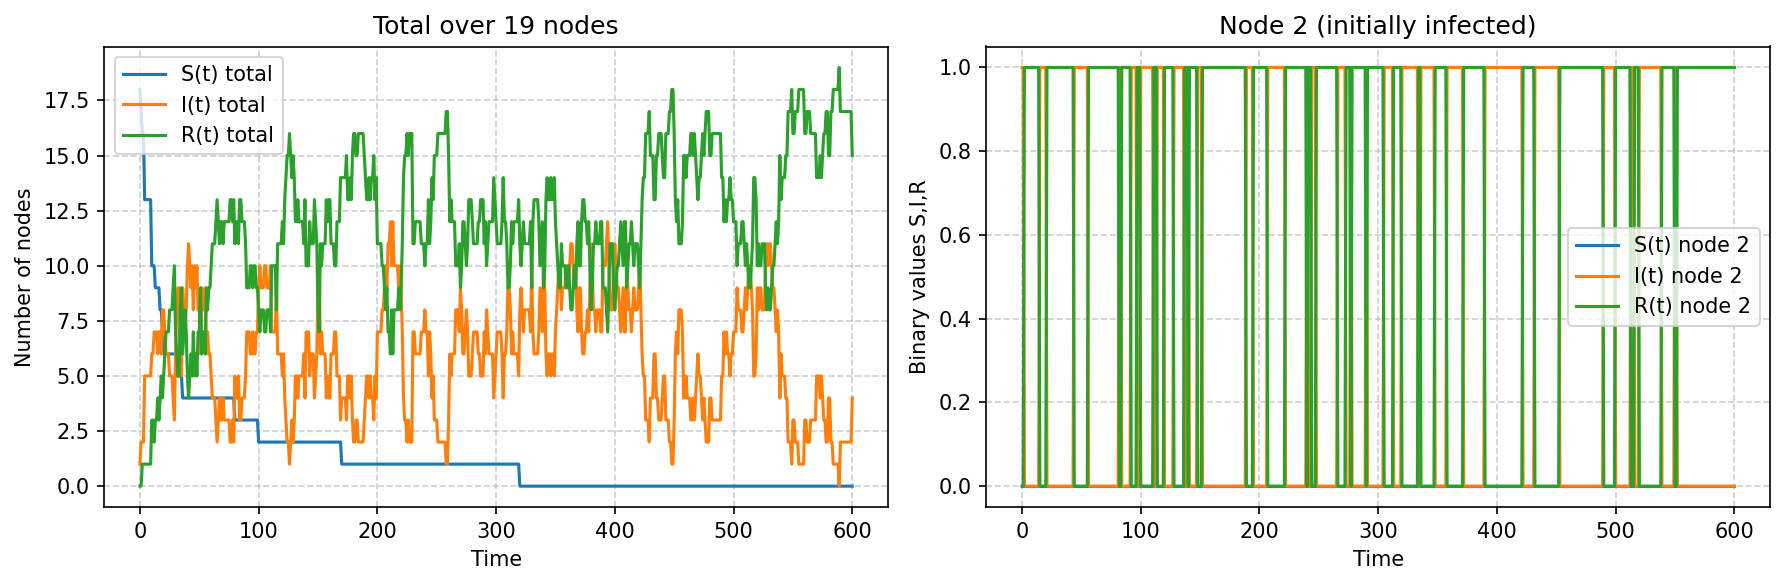

In [22]:
#infected = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]   # warning: if starting from 0, 3 is the fourth node

infected = [2]
#infected = [8,16,0] nodes with highest positive outdegree
#infected = [11,10,2] nodes with lower positive outdegree
#infected = [18,1,4] nodes with highest negative outdegree
#infected = [0,1,4] nodes with highest betweenness
#infected = [2,6,11] nodes with highest clustering coefficient

S, I, R, steps = ire_model_stochastic_RandomInfected(
    beta=1,
    mu=0.1,
    C=C,
    C_neg=C_neg,
    Nk=Nk,
    T_final=600,
    dt=1,
    infected_nodes=infected,
    seed=42
)

total_S = np.sum(S, axis=1)
total_I = np.sum(I, axis=1)
total_R = np.sum(R, axis=1)

# Node 2
node2_S = S[:, 2]
node2_I = I[:, 2]
node2_R = R[:, 2]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

# Total plot
axes[0].plot(total_S, label="S(t) total")
axes[0].plot(total_I, label="I(t) total")
axes[0].plot(total_R, label="R(t) total")
axes[0].set_title("Total over 19 nodes")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Number of nodes")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.6)

# Node 2 plot
axes[1].plot(node2_S, label="S(t) node 2")
axes[1].plot(node2_I, label="I(t) node 2")
axes[1].plot(node2_R, label="R(t) node 2")
axes[1].set_title("Node 2 (initially infected)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Binary values S,I,R")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

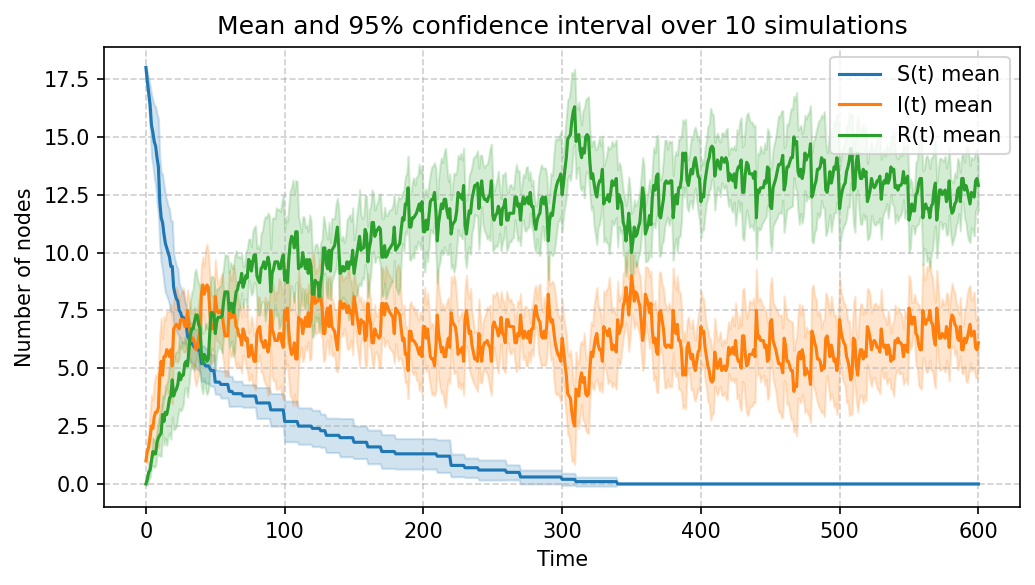

In [23]:
infected = [2]
#infected = [8,16,0]
#infected = [11,10,2]
#infected = [18,1,4]
#infected = [0,1,4]
#infected = [2,6,11]


num_sim = 10
seeds = range(num_sim)

# Lists to save results
S_all, I_all, R_all = [], [], []

for seed in seeds:
    S, I, R, steps = ire_model_stochastic_RandomInfected(
        beta=1,
        mu=0.1,
        #mu=0.01,
        C=C,
        C_neg=C_neg,
        Nk=Nk,
        T_final=600,
        dt=1,
        infected_nodes=infected,
        seed=seed
    )

    total_S = np.sum(S, axis=1)
    total_I = np.sum(I, axis=1)
    total_R = np.sum(R, axis=1)

    S_all.append(total_S)
    I_all.append(total_I)
    R_all.append(total_R)

# Convert to array [num_sim, num_steps]
S_all = np.array(S_all)
I_all = np.array(I_all)
R_all = np.array(R_all)

# Mean and 95% confidence interval
mean_S = np.mean(S_all, axis=0)
mean_I = np.mean(I_all, axis=0)
mean_R = np.mean(R_all, axis=0)

# Calculate 95% CI (approximating with normal distribution)
std_S = np.std(S_all, axis=0, ddof=1)
std_I = np.std(I_all, axis=0, ddof=1)
std_R = np.std(R_all, axis=0, ddof=1)
ci_mult = 1.96 / np.sqrt(num_sim)  # 95% CI
ci_S = std_S * ci_mult
ci_I = std_I * ci_mult
ci_R = std_R * ci_mult

# Plot
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)
time = np.arange(len(mean_S))

# Mean + confidence band
ax.plot(time, mean_S, label="S(t) mean", color="tab:blue")
ax.fill_between(time, mean_S - ci_S, mean_S + ci_S, color="tab:blue", alpha=0.2)

ax.plot(time, mean_I, label="I(t) mean", color="tab:orange")
ax.fill_between(time, mean_I - ci_I, mean_I + ci_I, color="tab:orange", alpha=0.2)

ax.plot(time, mean_R, label="R(t) mean", color="tab:green")
ax.fill_between(time, mean_R - ci_R, mean_R + ci_R, color="tab:green", alpha=0.2)

ax.set_title("Mean and 95% confidence interval over 10 simulations")
ax.set_xlabel("Time")
ax.set_ylabel("Number of nodes")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## 7) Stochastic Compartimental Model with Contact Matrices, Random Infections and Permanent Node Recovery over Time: exploring Strategies of "Vaccination" through Centrality Metrics

Finally, we introduce **node vaccination**. The idea is to simulate the possibility for an individual to access interventions such as psychotherapy or medication, which can attenuate symptoms. In the model, vaccination is implemented by **permanently setting one node to the recovered state ($R$) every 300 $dt$**, meaning the node no longer participates in the dynamics.

Now the aim is to investigate how the epidemic can be “turned off” in the network by vaccinating nodes according to different ordered lists, and to determine **which strategy is the most effective**. The order in which nodes are vaccinated follows lists of indices sorted according to the following criteria (different **vaccination strategies):**


- **Random**  
- **Outdegree (positive) descending**  
- **Outdegree (positive) ascending**  
- **Betweenness descending**  
- **Clustering coefficient descending**

To measure differences between vaccination strategies, a time $T^*$ is defined as the first moment when the number of infected nodes remains **below 4 for 100 consecutive timesteps**, thereby avoiding stochastic fluctuations. By varying the random seed, multiple $T^*$ values are computed for each strategy, and their distributions are visualized using **box plots**.


In [24]:
def ire_model_stochastic_RandomInfected_ForcingRecovery(beta, mu, C, C_neg, Nk, T_final, dt=1, infected_nodes=None, seed=None, shutdown_order=None):
    if seed is not None:
        rng = np.random.default_rng(seed)  # local generator
    else:
        rng = np.random.default_rng()      # random generator
        
    steps = np.arange(0, T_final + dt, dt)
    n_nodes = 19
    S, I, R = np.zeros((len(steps), n_nodes)), np.zeros((len(steps), n_nodes)), np.zeros((len(steps), n_nodes))
  
    S[0] = Nk.copy()
    I[0] = 0
    
    if infected_nodes is None:
        infected_nodes = []

    for node in infected_nodes:
        I[0, node] = 1
        S[0, node] -= 1

    active_nodes = np.ones(n_nodes, dtype=bool)

    # index to track which node to shut down next
    shutdown_index = 0

    for t in range(1, len(steps)):
        S_next, I_next, R_next = S[t-1].copy(), I[t-1].copy(), R[t-1].copy()

        for k in range(n_nodes):
            if not active_nodes[k]:
                continue

            new_infected_k = rng.binomial(S[t-1, k], beta * np.sum(C.T[k, :] * I[t-1, :] / Nk) * dt)
            new_recovered_k = rng.binomial(I[t-1, k], mu * dt)
            new_infected_k_1 = rng.binomial(R[t-1, k], beta * np.sum(C.T[k, :] * I[t-1, :] / Nk) * dt)
            new_recovered_k_1 = rng.binomial(I[t-1, k], np.sum(- beta * C_neg.T[k, :] * I[t-1, :] / Nk) * dt)

            S_next[k] = S[t-1, k] - new_infected_k
            I_next[k] = I[t-1, k] + new_infected_k - new_recovered_k + new_infected_k_1 - new_recovered_k_1
            R_next[k] = R[t-1, k] + new_recovered_k - new_infected_k_1 + new_recovered_k_1
            
            # discrete state (0/1)
            if S_next[k] > 0:
                S_next[k], I_next[k], R_next[k] = 1, 0, 0
            elif I_next[k] > 0:
                S_next[k], I_next[k], R_next[k] = 0, 1, 0
            elif R_next[k] > 0:
                S_next[k], I_next[k], R_next[k] = 0, 0, 1

        # force 2 random nodes to be infected every 10 timestep
        if t % 10 == 0:
            candidate_nodes = np.where(active_nodes)[0]
            if len(candidate_nodes) > 0:
                random_nodes = rng.choice(candidate_nodes, size=min(2, len(candidate_nodes)), replace=False)
                for node in random_nodes:
                    S_next[node], I_next[node], R_next[node] = 0, 1, 0

        # every 300 timestep, controlled shutdown of nodes
        if t % 300 == 0:
            if shutdown_order is not None and shutdown_index < len(shutdown_order):
                node_to_R = shutdown_order[shutdown_index]
                if active_nodes[node_to_R]:  # only if still active
                    S_next[node_to_R], I_next[node_to_R], R_next[node_to_R] = 0, 0, 1
                    active_nodes[node_to_R] = False
                shutdown_index += 1

        S[t] = S_next
        I[t] = I_next
        R[t] = R_next
        
    return np.array(S), np.array(I), np.array(R), np.array(steps)


In [25]:
n_nodes = 19 
rng = np.random.default_rng(seed=42) 
shutdown_random = rng.permutation(n_nodes).tolist()

#print(shutdown_random)

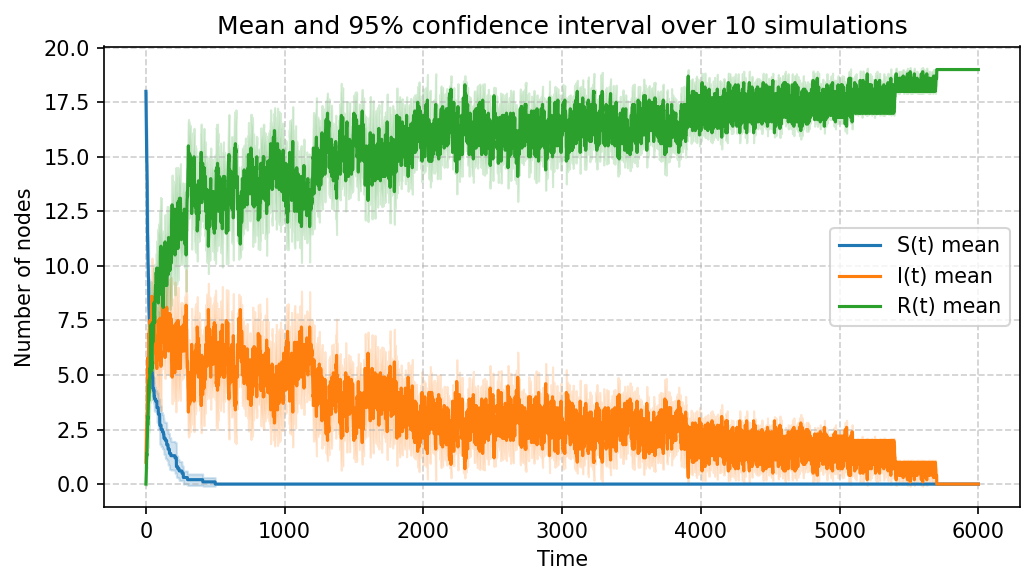

In [26]:
infected = [2]
#infected = [8,16,0]
#infected = [11,10,2]
#infected = [18,1,4]
#infected = [0,1,4]
#infected = [2,6,11]

num_sim = 10
seeds = range(num_sim)

# Lists to save results
S_all, I_all, R_all = [], [], []

for seed in seeds:
    S, I, R, steps = ire_model_stochastic_RandomInfected_ForcingRecovery(
        beta=1,
        mu=0.1,
        #mu=0.01,
        C=C,
        C_neg=C_neg,
        Nk=Nk,
        T_final=6000,
        dt=1,
        infected_nodes=infected,
        seed=seed,
        shutdown_order=shutdown_random
    )

    total_S = np.sum(S, axis=1)
    total_I = np.sum(I, axis=1)
    total_R = np.sum(R, axis=1)

    S_all.append(total_S)
    I_all.append(total_I)
    R_all.append(total_R)

# Convert to array [num_sim, num_steps]
S_all = np.array(S_all)
I_all = np.array(I_all)
R_all = np.array(R_all)

# Mean and 95% confidence interval
mean_S = np.mean(S_all, axis=0)
mean_I = np.mean(I_all, axis=0)
mean_R = np.mean(R_all, axis=0)

# Calculate 95% CI (approximating with normal distribution)
std_S = np.std(S_all, axis=0, ddof=1)
std_I = np.std(I_all, axis=0, ddof=1)
std_R = np.std(R_all, axis=0, ddof=1)
ci_mult = 1.96 / np.sqrt(num_sim)  # 95% CI
ci_S = std_S * ci_mult
ci_I = std_I * ci_mult
ci_R = std_R * ci_mult

# Plot
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)
time = np.arange(len(mean_S))

# Mean + confidence band
ax.plot(time, mean_S, label="S(t) mean", color="tab:blue")
ax.fill_between(time, mean_S - ci_S, mean_S + ci_S, color="tab:blue", alpha=0.2)

ax.plot(time, mean_I, label="I(t) mean", color="tab:orange")
ax.fill_between(time, mean_I - ci_I, mean_I + ci_I, color="tab:orange", alpha=0.2)

ax.plot(time, mean_R, label="R(t) mean", color="tab:green")
ax.fill_between(time, mean_R - ci_R, mean_R + ci_R, color="tab:green", alpha=0.2)

ax.set_title("Mean and 95% confidence interval over 10 simulations")
ax.set_xlabel("Time")
ax.set_ylabel("Number of nodes")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


##### Trying different strategies of vaccination 
The lists used for the order of "vaccination" were defined in section 4)

In [27]:
#print(outdegree_pos_descendent)
#print(outdegree_pos_ascendent)
#print(betweeness_pos_descendent)
#print(betweeness_pos_ascendent)
#print(clustering_pos_descendent)
#print(clustering_pos_ascendent)
#print(shutdown_random)

Now we start the simulation with no initially infected nodes, leaving only the random infection dynamics of two nodes every 10 timesteps. We then compare the different "vaccination" strategies using boxplots.


In [28]:
infected = []

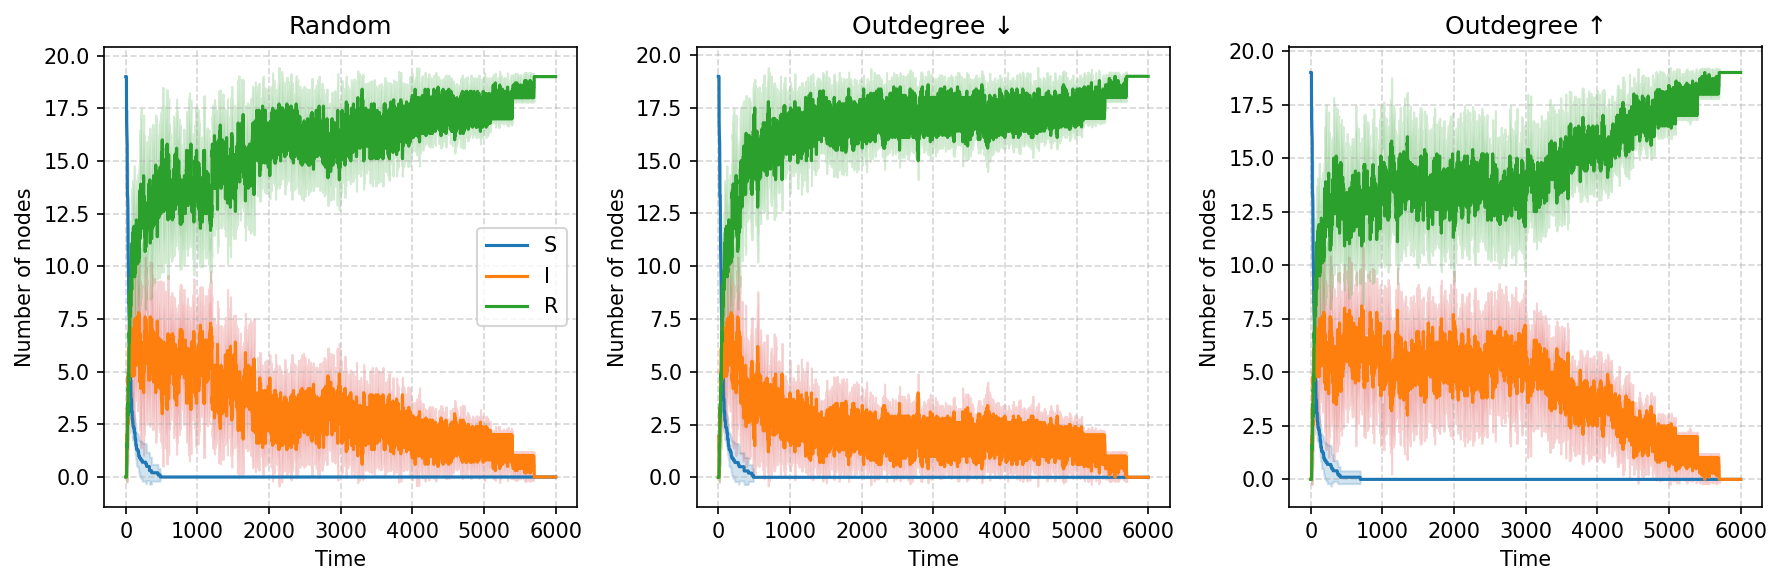

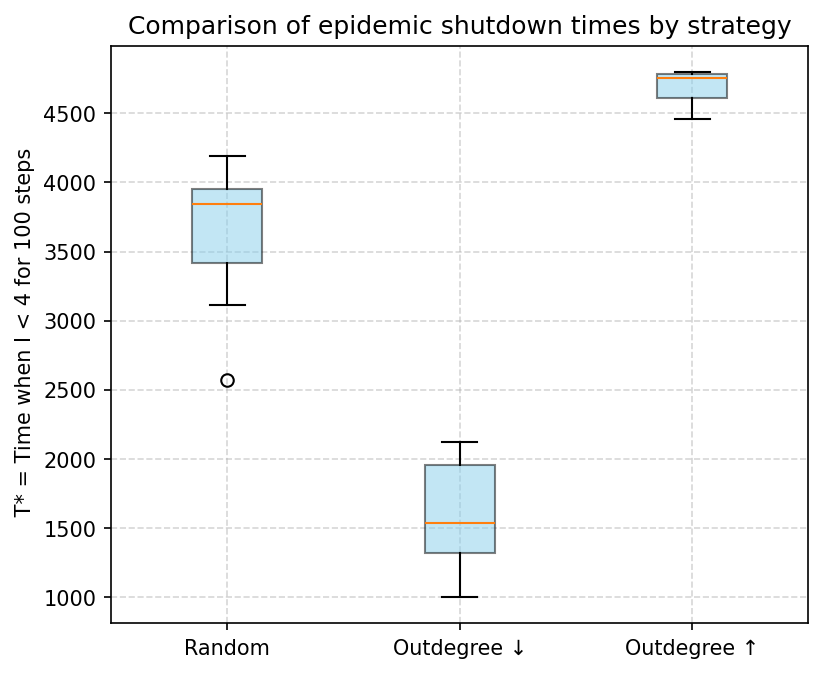

In [29]:
strategies = {
    "Random": shutdown_random,
    "Outdegree ↓": outdegree_pos_descendent,
    "Outdegree ↑": outdegree_pos_ascendent
}

n_seeds = range(20, 30)  # 30 simulations
threshold = 4
consecutive_points = 100

# Dictionary to save final times for each strategy
times_to_below_threshold = {}

plt.figure(figsize=(12,4), dpi=150)

for i, (name, shutdown_order) in enumerate(strategies.items(), 1):
    all_S, all_I, all_R = [], [], []
    times_below = []

    for seed in n_seeds:
        S_sim, I_sim, R_sim, steps = ire_model_stochastic_RandomInfected_ForcingRecovery(
            beta=1,
            mu=0.1,
            C=C,
            C_neg=C_neg,
            Nk=Nk,
            T_final=6000,
            dt=1,
            infected_nodes=infected,
            seed=seed,
            shutdown_order=shutdown_order
        )
        total_I = np.sum(I_sim, axis=1)
        all_S.append(np.sum(S_sim, axis=1))
        all_I.append(total_I)
        all_R.append(np.sum(R_sim, axis=1))

        # Find first time I < threshold for at least consecutive_points
        below_idx = np.where(total_I < threshold)[0]
        found = False
        for idx in below_idx:
            if idx + consecutive_points < len(total_I) and np.all(total_I[idx:idx+consecutive_points] < threshold):
                times_below.append(steps[idx])
                found = True
                break
        if not found:
            times_below.append(np.nan)  # if it never happens

    times_to_below_threshold[name] = times_below

    # Compute mean and std
    mean_S = np.mean(all_S, axis=0)
    mean_I = np.mean(all_I, axis=0)
    mean_R = np.mean(all_R, axis=0)

    std_S = np.std(all_S, axis=0)
    std_I = np.std(all_I, axis=0)
    std_R = np.std(all_R, axis=0)

    # Subplot for each strategy
    plt.subplot(1, 3, i)
    plt.plot(steps, mean_S, color="tab:blue", label="S")
    plt.fill_between(steps, mean_S-std_S, mean_S+std_S, color="tab:blue", alpha=0.2)
    plt.plot(steps, mean_I, color="tab:orange", label="I")
    plt.fill_between(steps, mean_I-std_I, mean_I+std_I, color="tab:red", alpha=0.2)
    plt.plot(steps, mean_R, color="tab:green", label="R")
    plt.fill_between(steps, mean_R-std_R, mean_R+std_R, color="tab:green", alpha=0.2)
    plt.title(name)
    plt.xlabel("Time")
    plt.ylabel("Number of nodes")
    plt.grid(True, linestyle="--", alpha=0.5)
    if i==1:
        plt.legend()

plt.tight_layout()
plt.show()

# --- Boxplot of times ---
plt.figure(figsize=(6,5), dpi=150)
data = [times_to_below_threshold[name] for name in strategies.keys()]
plt.boxplot(data, labels=strategies.keys(), patch_artist=True,
            boxprops=dict(facecolor="skyblue", alpha=0.5))
plt.ylabel(f" T* = Time when I < {threshold} for {consecutive_points} steps")
plt.title("Comparison of epidemic shutdown times by strategy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:
strategies = {
    "Outdegree ↓": outdegree_pos_descendent,
    "Betweeness ↓": betweeness_pos_descendent,
    "Clustering ↓": clustering_pos_descendent
}

n_seeds = range(20, 30)  # 30 simulations
threshold = 4
consecutive_points = 100

# Dictionary to save final times for each strategy
times_to_below_threshold = {}

plt.figure(figsize=(12,4), dpi=150)

for i, (name, shutdown_order) in enumerate(strategies.items(), 1):
    all_S, all_I, all_R = [], [], []
    times_below = []

    for seed in n_seeds:
        S_sim, I_sim, R_sim, steps = ire_model_stochastic_RandomInfected_ForcingRecovery(
            beta=1,
            mu=0.1,
            C=C,
            C_neg=C_neg,
            Nk=Nk,
            T_final=6000,
            dt=1,
            infected_nodes=infected,
            seed=seed,
            shutdown_order=shutdown_order
        )
        total_I = np.sum(I_sim, axis=1)
        all_S.append(np.sum(S_sim, axis=1))
        all_I.append(total_I)
        all_R.append(np.sum(R_sim, axis=1))

        # Find first time I < threshold for at least consecutive_points
        below_idx = np.where(total_I < threshold)[0]
        found = False
        for idx in below_idx:
            if idx + consecutive_points < len(total_I) and np.all(total_I[idx:idx+consecutive_points] < threshold):
                times_below.append(steps[idx])
                found = True
                break
        if not found:
            times_below.append(np.nan)  # if it never happens

    times_to_below_threshold[name] = times_below

    # Compute mean and std
    mean_S = np.mean(all_S, axis=0)
    mean_I = np.mean(all_I, axis=0)
    mean_R = np.mean(all_R, axis=0)

    std_S = np.std(all_S, axis=0)
    std_I = np.std(all_I, axis=0)
    std_R = np.std(all_R, axis=0)

    # Subplot for each strategy
    plt.subplot(1, 3, i)
    plt.plot(steps, mean_S, color="tab:blue", label="S")
    plt.fill_between(steps, mean_S-std_S, mean_S+std_S, color="tab:blue", alpha=0.2)
    plt.plot(steps, mean_I, color="tab:orange", label="I")
    plt.fill_between(steps, mean_I-std_I, mean_I+std_I, color="tab:red", alpha=0.2)
    plt.plot(steps, mean_R, color="tab:green", label="R")
    plt.fill_between(steps, mean_R-std_R, mean_R+std_R, color="tab:green", alpha=0.2)
    plt.title(name)
    plt.xlabel("Time")
    plt.ylabel("Number of nodes")
    plt.grid(True, linestyle="--", alpha=0.5)
    if i==1:
        plt.legend()

plt.tight_layout()
plt.show()

# --- Boxplot of times ---
plt.figure(figsize=(6,5), dpi=150)
data = [times_to_below_threshold[name] for name in strategies.keys()]
plt.boxplot(data, labels=strategies.keys(), patch_artist=True,
            boxprops=dict(facecolor="skyblue", alpha=0.5))
plt.ylabel(f" T* =  Time when I < {threshold} for {consecutive_points} steps")
plt.title("Comparison of epidemic shutdown times by strategy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
